# Sobre
- Autores: Enzo Rigon e Gabriel Musskopf
- Dataset: https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data
- Slides: https://asavbrm-my.sharepoint.com/:b:/g/personal/gmusskopf_edu_unisinos_br/IQBeuL8vealjTrRBUkBNF24VAR8QZnUWI-2lid9BGIx7Nho?e=n0vb2H
- Apresentação: https://asavbrm-my.sharepoint.com/:v:/g/personal/gmusskopf_edu_unisinos_br/IQCLYeWgMJ6eTID_lfQLeru6AaA21avPKeNbKhBpV0QFvK0?e=SwOo6B&nav=eyJyZWZlcnJhbEluZm8iOnsicmVmZXJyYWxBcHAiOiJTdHJlYW1XZWJBcHAiLCJyZWZlcnJhbFZpZXciOiJTaGFyZURpYWxvZy1MaW5rIiwicmVmZXJyYWxBcHBQbGF0Zm9ybSI6IldlYiIsInJlZmVycmFsTW9kZSI6InZpZXcifX0%3D

## Estrutura
Para facilitar o desenvolvimento e tempo de execução, separamos em três notebooks distintos. Mais informações sobre no README.md.

# Pipeline de Análise e Classificação de Crédito
Este notebook executa todas as etapas do processamento, limpeza, seleção de variáveis, modelagem e avaliação de um dataset de crédito. Veja o passo a passo abaixo:

In [146]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Passo 1: Começamos dropando as colunas com o credit score 0 (que no dataset original era usado para teste mas não estaremos usando)

Primeiro, removemos os registros onde o Credit_Score está ausente ou igual a zero, pois esses dados eram utilizados apenas para teste no dataset original e não serão usados na classificação.

In [147]:
df = pd.read_csv('cleaned_data.csv')
df = df[df['Credit_Score'].notna()]

/var/folders/p4/jnb87qbx4_d13sj5n8tn96vw0000gn/T/ipykernel_27151/1306290490.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')


In [148]:
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
print(cat_cols)
print(f"Number of categorical columns: {len(cat_cols)}")

['ID', 'Customer_ID', 'Month', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']
Number of categorical columns: 10


# Passo 2: Aplicação de LabelEncoder e OneHotEncoder
Neste passo, utilizamos o LabelEncoder para transformar variáveis categóricas ordinais em valores numéricos e o OneHotEncoder para criar variáveis dummies das colunas categóricas nominais. Essa etapa é fundamental para preparar os dados para os algoritmos de machine learning, que exigem variáveis numéricas e codificadas corretamente.

In [149]:
# Removi essas colunas especificas por que tem muitos valores únicos e acabam atrapalhando o modelo
df = df.drop(columns=['Credit_History_Age', 'Type_of_Loan'])

In [150]:
one_hot_columns = ['Month', 'Occupation', 'Payment_Behaviour']
label_columns = ['Credit_Mix', 'Payment_of_Min_Amount', 'Credit_Score']

In [151]:
le = LabelEncoder()
for col in label_columns:
    df[col] = le.fit_transform(df[col].astype(str))

print(df.head())

       ID Customer_ID     Month        Age Occupation  Annual_Income  \
0  0x1602   CUS_0xd40   January  23.000000  Scientist       19114.12   
1  0x1603   CUS_0xd40  February  23.000000  Scientist       19114.12   
2  0x1604   CUS_0xd40     March  23.272727  Scientist       19114.12   
3  0x1605   CUS_0xd40     April  23.000000  Scientist       19114.12   
4  0x1606   CUS_0xd40       May  23.000000  Scientist       19114.12   

   Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  \
0            1824.843333                3.0              4.0            3.0   
1            1824.843333                3.0              4.0            3.0   
2            1824.843333                3.0              4.0            3.0   
3            1824.843333                3.0              4.0            3.0   
4            1824.843333                3.0              4.0            3.0   

   ...  Num_Credit_Inquiries  Credit_Mix  Outstanding_Debt  \
0  ...                   4.0  

In [152]:
he = OneHotEncoder(sparse_output=False, drop='first')
encoded = he.fit_transform(df[one_hot_columns])
encoded_df = pd.DataFrame(encoded, columns=he.get_feature_names_out(one_hot_columns), index=df.index)
df = pd.concat([df.drop(columns=one_hot_columns), encoded_df], axis=1)
print(df.head())
print(f"Dataframe shape after encoding: {df.shape}")

       ID Customer_ID        Age  Annual_Income  Monthly_Inhand_Salary  \
0  0x1602   CUS_0xd40  23.000000       19114.12            1824.843333   
1  0x1603   CUS_0xd40  23.000000       19114.12            1824.843333   
2  0x1604   CUS_0xd40  23.272727       19114.12            1824.843333   
3  0x1605   CUS_0xd40  23.000000       19114.12            1824.843333   
4  0x1606   CUS_0xd40  23.000000       19114.12            1824.843333   

   Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
0                3.0              4.0            3.0          4.0   
1                3.0              4.0            3.0          4.0   
2                3.0              4.0            3.0          4.0   
3                3.0              4.0            3.0          4.0   
4                3.0              4.0            3.0          4.0   

   Delay_from_due_date  ...  Occupation_Media_Manager  Occupation_Musician  \
0             3.000000  ...                       0.0         

# Passo 3: Análise de correlação para seleção de features
Neste passo, plotamos a matriz de correlação entre as colunas numéricas do dataset. Essa visualização permite identificar relações fortes entre variáveis, facilitando a escolha das features mais relevantes para o modelo de classificação. A análise de correlação é fundamental para evitar redundância e melhorar a performance dos algoritmos.

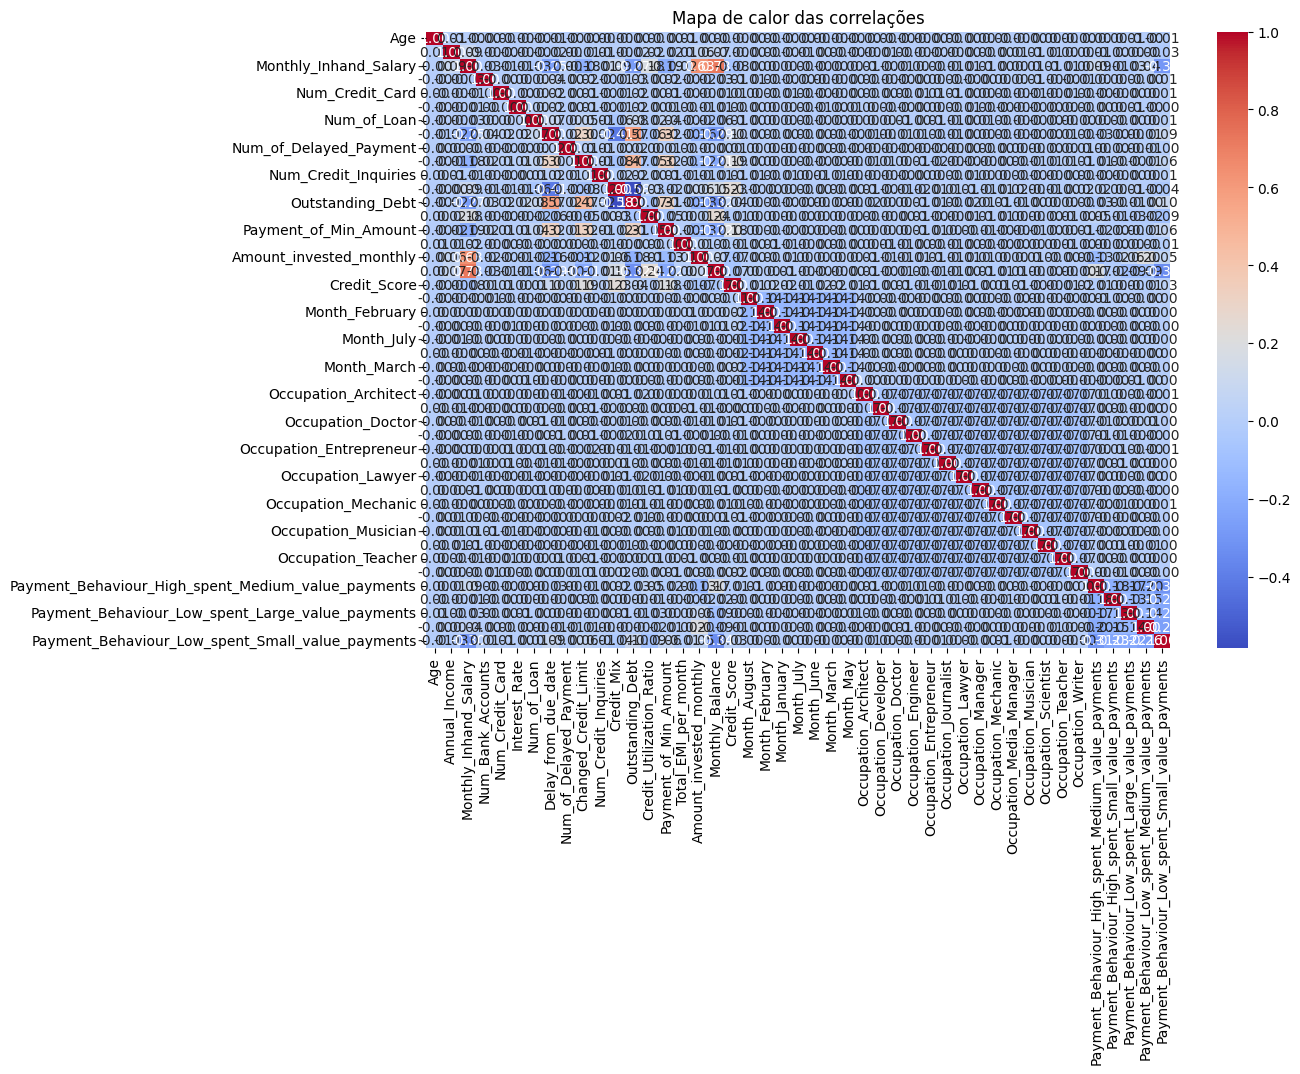

In [153]:
num_df = df.select_dtypes(include=[np.number])
corr_matrix = num_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mapa de calor das correlações")
plt.show()

# Passo 4: Seleção das colunas com maior correlação
Neste passo, preservamos apenas as colunas que apresentam maior correlação entre si ou com a variável alvo. Essa seleção reduz a dimensionalidade do dataset e garante que o modelo trabalhe apenas com as variáveis mais relevantes, aumentando a eficiência e a qualidade da classificação.

In [154]:
high_corr = (
    corr_matrix
    .abs()
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr.columns = ['coluna_1', 'coluna_2', 'correlacao']
result = high_corr[high_corr['correlacao'] > 0.5]

cols_corr = set(result['coluna_1']).union(set(result['coluna_2']))
df_high_corr = df[list(cols_corr)]

print(df_high_corr.columns)

Index(['Credit_Mix', 'Monthly_Balance', 'Outstanding_Debt',
       'Amount_invested_monthly', 'Monthly_Inhand_Salary',
       'Delay_from_due_date'],
      dtype='object')


In [155]:
for col in df_high_corr.columns:
    min_val = df_high_corr[col].min()
    max_val = df_high_corr[col].max()
    print(f"Coluna: {col}, Min: {min_val}, Max: {max_val}")


Coluna: Credit_Mix, Min: 0, Max: 2
Coluna: Monthly_Balance, Min: 0.0077596647753352, Max: 1576.2889354369515
Coluna: Outstanding_Debt, Min: 0.23, Max: 4998.07
Coluna: Amount_invested_monthly, Min: 0.0, Max: 1944.5207468791525
Coluna: Monthly_Inhand_Salary, Min: 303.6454166666666, Max: 15204.633333333331
Coluna: Delay_from_due_date, Min: 0.0, Max: 67.0


In [156]:
cols = list(df_high_corr.columns) + ['Credit_Score']
df = df[cols]
print(df.head())

   Credit_Mix  Monthly_Balance  Outstanding_Debt  Amount_invested_monthly  \
0           1       312.494089            809.98                80.415295   
1           1       284.629162            809.98               118.280222   
2           1       331.209863            809.98                81.699521   
3           1       223.451310            809.98               199.458074   
4           1       341.489231            809.98                41.420153   

   Monthly_Inhand_Salary  Delay_from_due_date  Credit_Score  
0            1824.843333             3.000000             0  
1            1824.843333             3.666667             0  
2            1824.843333             3.000000             0  
3            1824.843333             5.000000             0  
4            1824.843333             6.000000             0  


# Passo 5: Remoção de Outliers com IQR

Neste passo, removemos outliers das colunas numéricas utilizando o método do Intervalo Interquartil (IQR). Outliers podem distorcer a análise estatística e prejudicar o desempenho dos modelos de machine learning. O método IQR identifica valores extremos que estão fora do intervalo esperado para cada variável.

In [157]:
def detect_outliers_iqr(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    outlier_mask = pd.DataFrame(False, index=df.index, columns=num_cols)
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_mask[col] = (df[col] < lower) | (df[col] > upper)
    return outlier_mask

def remove_outliers_iqr_mask(df):
    outlier_mask = detect_outliers_iqr(df)
    # Remove linhas que são outlier em pelo menos uma coluna
    mask = ~outlier_mask.any(axis=1)
    return df[mask].reset_index(drop=True)

print(len(df))
df = remove_outliers_iqr_mask(df)
print(len(df))
print(df.columns)

95695
73750
Index(['Credit_Mix', 'Monthly_Balance', 'Outstanding_Debt',
       'Amount_invested_monthly', 'Monthly_Inhand_Salary',
       'Delay_from_due_date', 'Credit_Score'],
      dtype='object')


> **Observação:** Após a remoção de outliers utilizando o método IQR, muitos registros foram excluídos do dataset. Isso ocorre porque cada cliente possui vários registros e, caso um cliente seja considerado outlier em alguma variável, todos os seus registros acabam sendo removidos do conjunto de dados.

# Passo 6: Normalização das features selecionadas

Após selecionar as colunas com maior correlação, aplicamos a normalização MinMaxScaler para padronizar os valores dessas variáveis entre 0 e 1. Isso garante que todas as features estejam na mesma escala, evitando que variáveis com valores maiores dominem o treinamento dos modelos. A normalização é especialmente importante para algoritmos que utilizam distância ou pesos, como SVM e redes neurais.

In [158]:
cols_to_scale = [col for col in df.columns if col != 'Credit_Score']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

print(df.describe())
print(len(df))

         Credit_Mix  Monthly_Balance  Outstanding_Debt  \
count  73750.000000     73750.000000      73750.000000   
mean       0.657959         0.476296          0.320504   
std        0.392536         0.177752          0.231207   
min        0.000000         0.000000          0.000000   
25%        0.500000         0.353885          0.139248   
50%        1.000000         0.430250          0.284989   
75%        1.000000         0.564050          0.443826   
max        1.000000         1.000000          1.000000   

       Amount_invested_monthly  Monthly_Inhand_Salary  Delay_from_due_date  \
count             73750.000000           73750.000000         73750.000000   
mean                  0.306214               0.248586             0.357627   
std                   0.214738               0.183537             0.230916   
min                   0.000000               0.000000             0.000000   
25%                   0.145090               0.102483             0.181818   
50%      

# Passo 7: Treinamento do Modelo Random Forest

Neste passo, realizamos a preparação dos dados e o treinamento do modelo Random Forest para classificação do crédito dos clientes. Selecionamos apenas as variáveis com maior correlação e a variável alvo, dividimos o conjunto em treino e teste, e ajustamos o modelo Random Forest. Após o treinamento, o modelo estará pronto para realizar previsões e ser avaliado nas próximas etapas.

In [159]:
cols = list(df_high_corr.columns) + ['Credit_Score']
X = df[cols].drop(columns=['Credit_Score'])
y = df['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_imp = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)
model_imp.fit(X_train, y_train)

,n_estimators,50
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [160]:
y_pred = model_imp.predict(X_test)

print('Acurácia:', accuracy_score(y_test, y_pred))
print('Precisão:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))
print('\nRelatório de classificação:')
print(classification_report(y_test, y_pred))

Acurácia: 0.708406779661017
Precisão: 0.7346746959176739
Recall: 0.708406779661017
F1-score: 0.7129549107098342

Relatório de classificação:
              precision    recall  f1-score   support

           0       0.54      0.79      0.64      2510
           1       0.68      0.73      0.70      4238
           2       0.83      0.67      0.74      8002

    accuracy                           0.71     14750
   macro avg       0.68      0.73      0.69     14750
weighted avg       0.73      0.71      0.71     14750



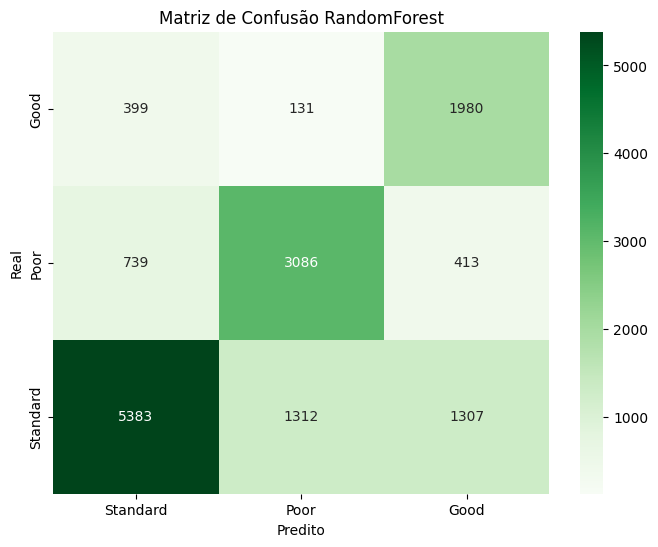

In [161]:
labels = le.inverse_transform([0, 1, 2])
labels_inv = labels[::-1]
cm_rf = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred), labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf[:, ::-1], annot=True, fmt='d', cmap='Greens', xticklabels=labels_inv, yticklabels=labels)
plt.title('Matriz de Confusão RandomForest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Passo 8: Avaliação do Modelo SVM

Neste passo, treinamos um modelo SVM (Support Vector Machine) com kernel RBF para classificar o crédito dos clientes. Após o treinamento, avaliamos o desempenho do modelo utilizando métricas como acurácia, precisão, recall e F1-score. Também apresentamos a matriz de confusão e o relatório de classificação para analisar os resultados em detalhes.

In [162]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print('Acurácia SVM:', accuracy_score(y_test, y_pred_svm))
print('Precisão SVM:', precision_score(y_test, y_pred_svm, average='weighted'))
print('Recall SVM:', recall_score(y_test, y_pred_svm, average='weighted'))
print('F1-score SVM:', f1_score(y_test, y_pred_svm, average='weighted'))
print('\nMatriz de confusão SVM:')
print(confusion_matrix(y_test, y_pred_svm))

print('\nRelatório de classificação SVM:')
print(classification_report(y_test, y_pred_svm))

Acurácia SVM: 0.675322033898305
Precisão SVM: 0.7034684925713013
Recall SVM: 0.675322033898305
F1-score SVM: 0.6796668325379766

Matriz de confusão SVM:
[[2040   96  374]
 [ 551 2712  975]
 [1404 1389 5209]]

Relatório de classificação SVM:
              precision    recall  f1-score   support

           0       0.51      0.81      0.63      2510
           1       0.65      0.64      0.64      4238
           2       0.79      0.65      0.72      8002

    accuracy                           0.68     14750
   macro avg       0.65      0.70      0.66     14750
weighted avg       0.70      0.68      0.68     14750



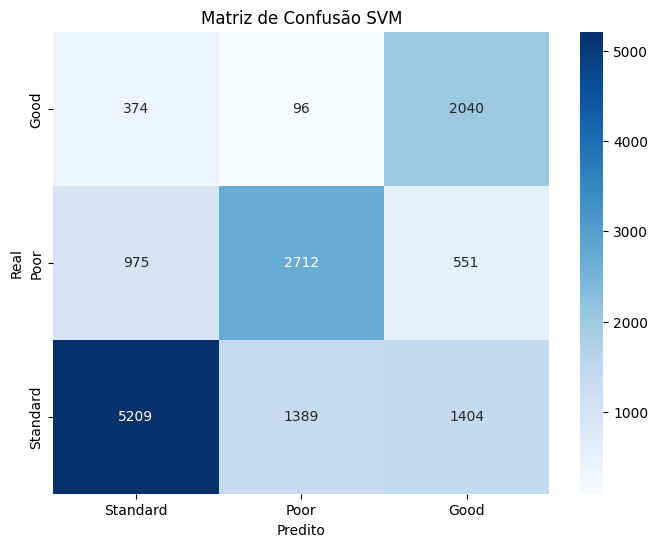

In [164]:
labels = le.inverse_transform([0, 1, 2])
labels_inv = labels[::-1]
cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred_svm), labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm[:, ::-1], annot=True, fmt='d', cmap='Blues', xticklabels=labels_inv, yticklabels=labels)
plt.title('Matriz de Confusão SVM')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Passo 9: Avaliação do Modelo XGBoost

Neste passo, treinamos o modelo XGBoost para classificar o crédito dos clientes. O XGBoost é um algoritmo de gradient boosting eficiente. Após o treinamento, avaliamos o desempenho do modelo utilizando métricas como acurácia, precisão, recall e F1-score, além do relatório de classificação detalhado.

In [166]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

le_target = LabelEncoder()
y_train_enc = le_target.fit_transform(y_train)
y_test_enc = le_target.transform(y_test)

xgb_model.fit(X_train, y_train_enc)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_labels = le_target.inverse_transform(y_pred_xgb)

print('Acurácia XGBoost:', accuracy_score(y_test_enc, y_pred_xgb))
print('Precisão XGBoost:', precision_score(y_test_enc, y_pred_xgb, average='weighted'))
print('Recall XGBoost:', recall_score(y_test_enc, y_pred_xgb, average='weighted'))
print('F1-score XGBoost:', f1_score(y_test_enc, y_pred_xgb, average='weighted'))
print('\nRelatório de classificação XGBoost:')
target_names = ['Standard', 'Poor', 'Good']  # ajuste conforme seus nomes originais
print(classification_report(y_test_enc, y_pred_xgb, target_names=target_names))

Acurácia XGBoost: 0.7465084745762712
Precisão XGBoost: 0.7520440488264297
Recall XGBoost: 0.7465084745762712
F1-score XGBoost: 0.7480733092361933

Relatório de classificação XGBoost:
              precision    recall  f1-score   support

    Standard       0.63      0.74      0.68      2510
        Poor       0.73      0.74      0.73      4238
        Good       0.80      0.75      0.78      8002

    accuracy                           0.75     14750
   macro avg       0.72      0.74      0.73     14750
weighted avg       0.75      0.75      0.75     14750



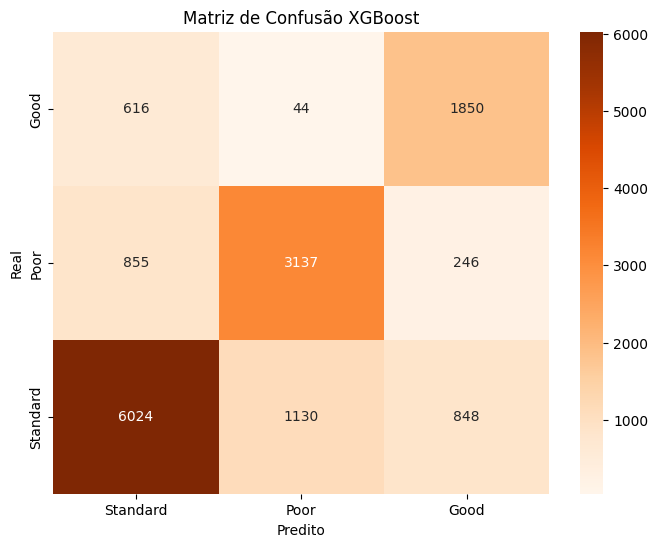

In [167]:
labels = le.inverse_transform([0, 1, 2])
labels_inv = labels[::-1]
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb, labels=range(len(labels)))
plt.figure(figsize=(8,6))
sns.heatmap(cm_xgb[:, ::-1], annot=True, fmt='d', cmap='Oranges', xticklabels=labels_inv, yticklabels=labels)
plt.title('Matriz de Confusão XGBoost')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()